# K-means, PCA e Árvore de Decisão

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler

### Conjunto de dados

In [2]:
dados = np.loadtxt('trab4.data', delimiter=',')
dados[:3]

array([[5.1, 3.5, 1.4, 0.2, 1. ],
       [4.9, 3. , 1.4, 0.2, 1. ],
       [4.7, 3.2, 1.3, 0.2, 1. ]])

#### Separando as *features* e a variável alvo

In [3]:
x = dados[:, :-1]
y = dados[:, -1]

In [4]:
x[:3]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

In [5]:
np.unique(y)

array([1., 2., 3.])

### K-means

<b> Implementação do k-means usando a distância euclidiana </b>

In [6]:
class KMeans():
    
    def __init__(self, k=2, max_iter=100, alpha=0.001):
        self.k = k
        self.max_iter = max_iter
        self.alpha = alpha
        
    def fit(self, X):
        
        # Inicializa os centróides
        self.cluster_c = self.calculate_initial_centroids(X)
        
        # Computa o cluster de cada amostra
        self.labels = self.all_nearest_centroids(X)
        
        # Calcula a inércia inicial
        old_inertia = self.inertia(X)
        
        for index in range(self.max_iter):
            self.cluster_centers_ = self.update_centroids(X)
            self.labels = self.all_nearest_centroids(X)
            
            self.inertia_value = self.inertia(X)
            
            if abs(old_inertia - self.inertia_value) <= self.alpha:
                break
            else:
                old_inertia = self.inertia_value
        return self
    
    def predict(self, X):
        return self.all_nearest_centroids(X)
    
    # Calcula os centróides iniciais
    def calculate_initial_centroids(self, X):
        minimo = np.min(X, axis=0)
        maximo = np.max(X, axis=0)

        centroids = np.random.uniform(minimo, maximo, [self.k, X.shape[1]])

        return centroids
    
    # Atualiza os centróides
    def update_centroids(self, X):
        for i, c in enumerate(self.cluster_c):
            pontos = X[self.labels == i]
            if pontos.shape[0] != 0:
                media = np.mean(pontos, axis=0)
                self.cluster_c[i] = media

        return self.cluster_c
    
    # Calcula o índice do centróide mais próximo para cada ponto do dataset
    def all_nearest_centroids(self, X):
        nd = np.zeros(X.shape[0])

        for i, p in enumerate(X):
            nd[i] = self.index_nearest_centroid(p)

        nearest_indexes = nd

        return nearest_indexes
    
    # Calcula o índice do centroid mais próximo ao ponto p
    def index_nearest_centroid(self, p):
        dc = np.zeros(len(self.cluster_c))

        for i, c in enumerate(self.cluster_c):
            dc[i] = self.euclidean_distance(p, c)

        nearest_index = np.argmin(dc)
        return nearest_index
    
    def euclidean_distance(self, a, b):
        return np.sqrt(np.sum(np.square(a-b)))
    
    # Métrica de avaliação
    def inertia(self, X):
        inertia_value = 0

        for i, p in enumerate(X):
            c = self.labels[i]
            c = self.cluster_c[np.int8(c)]
            inertia_value += self.euclidean_distance(p,c)**2

        return inertia_value

<b> a. Plote a distância média de cada ponto para o seu
centroide em um gráfico linha em função de k={2,3,4,5} (média
sobre 20 rodadas) </b>

In [18]:
inercias = []
for k in range(2,6):
    km = KMeans(k=k, max_iter=20)
    km.fit(x)
    inercias.append(km.inertia_value)
print(inercias)

[152.36870647733917, 78.94506582597724, 78.94506582597724, 57.35501904761905]


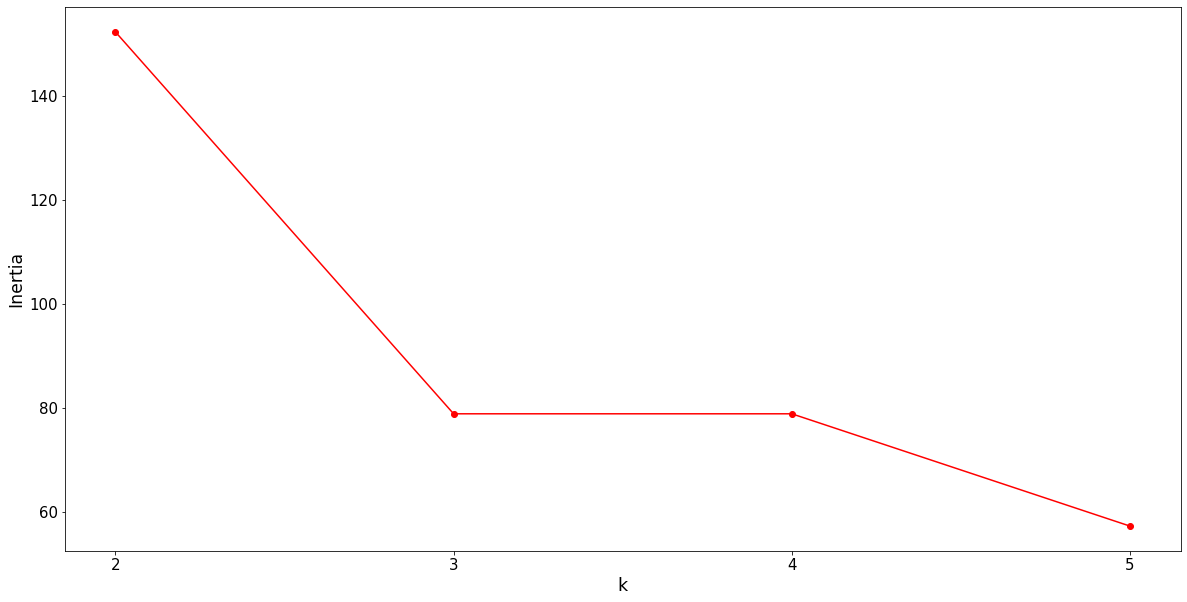

In [19]:
plt.figure(figsize=(20,10))
plt.plot(range(2,6), inercias, c='r', marker='o')
plt.xlabel('k', fontsize='xx-large')
plt.xticks(range(2,6))
plt.ylabel('Inertia', fontsize='xx-large')
plt.tick_params(labelsize=15)

plt.show()

<b> b. Discuta qual seria o k ideal a ser usado </b>

O valor de k ideal a ser utilizado, pode ser a partir de k=3, pois através do gráfico é possível observar que a distância média de cada ponto para o seu centróide vai diminuindo a partir desse valor.

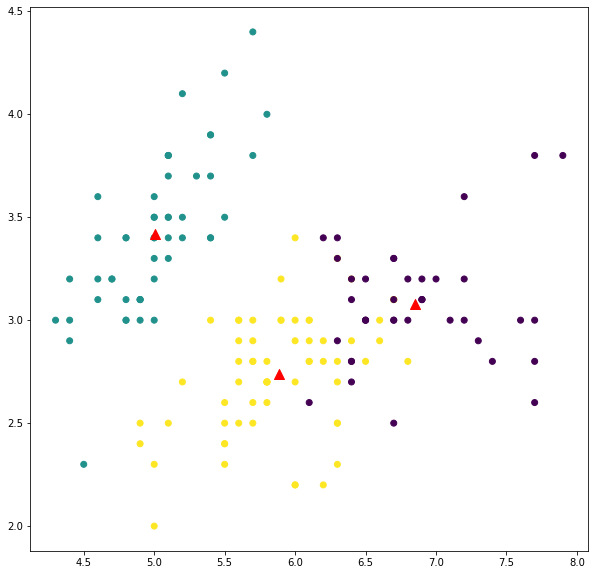

In [30]:
kmeans = KMeans(k=3)
kmeans.fit(x)

plt.figure(figsize=(10,10))
plt.scatter(dados[:,0], dados[:,1], c=kmeans.labels)
plt.scatter(kmeans.cluster_centers_[:,0], 
            kmeans.cluster_centers_[:,1], marker='^', c='red', s=100)
plt.show()

### PCA

In [32]:
class PCA():
    def __init__(self, n_comp):
        self.n_comp = n_comp
    
    def fit(self, x_):
        
        # Padronizar o conjunto de dados original
        std = StandardScaler()
        x = std.fit_transform(x_)
        
        # Construir a matriz de covariância
        cov_matrix = self.covariance_matrix(x)
        
        # Decompor a matriz de covariância em autovetores e autovalores
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        
        # Ordenar o autovalores em ordem decrescente juntamente com seus autovetores
        # Pega os índices dos valores ordenados em ordem decrescente
        indices = (-eigenvalues).argsort()[:self.n_comp]
        
        # Armazenar os primeiros n eigenvetors
        self.W = eigenvectors[:, indices]
        
        
        # Variância
        self.variances = np.array([])
        for i in indices:
            self.variances = np.append(self.variances, eigenvalues[i] / eigenvalues.sum())
        
    def transform(self, x_):
        std = StandardScaler()
        x = std.fit_transform(x_)
        
        return (self.W.T @ x.T).T
    
    def covariance_matrix(self, x):
        n = x.shape[0]
        mean = np.mean(x, axis=0)
        x_ = x - mean
        
        return (x_.T @ x_)/(n - 1)

<b> Reduza o conjunto de dados original em um conjunto com
apenas duas variáveis (2 componentes principais) </b>

In [33]:
pca = PCA(n_comp=2)
pca.fit(x)

x_ = pca.transform(x)

<b> a. Reporte quanto de variância foi preservado </b>

In [34]:
print("Variância preservada: ", pca.variances.sum())

Variância preservada:  0.9580097536148198


<b> b. Plote cada ponto do conjunto transformado em um
gráfico de dispersão 2d atribuindo uma cor para cada
uma das classes (3 classes no total). </b>

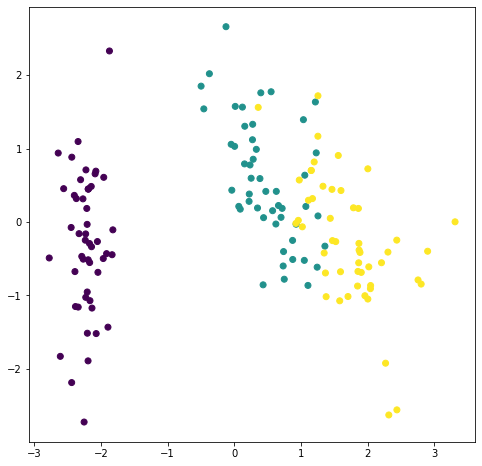

In [35]:
plt.figure(figsize=(8,8))
plt.scatter(x_[:,0], x_[:,1], c=y)

plt.show()

### Árvores de decisão

<b> Implemente a árvore de decisão usando o coeficiente de
Gini </b>

In [25]:
class TreeNode():
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [26]:
class DecisionTree():
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, x, y):
        self.n_feats = x.shape[1] if not self.n_feats else min(self.n_feats, x.shape[1])
        self.root = self._grow_tree(x, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return TreeNode(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # Seleciona a melhor divisão de acordo com o ganho de informação
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return TreeNode(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        parent_gini = self.gini(y)

        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self.gini(y[left_idxs]), self.gini(y[right_idxs])
        child_gini = (n_l / n) * e_l + (n_r / n) * e_r

        ig = parent_gini - child_gini
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common
    
    def gini(self, group):
        values, counts = np.unique(group, return_counts=True)
        
        tot = np.sum(counts)
        sum_sq = 0
        for i in counts:
            sum_sq += (i/tot)**2
        return 1 - sum_sq

<b>  
    Reporte o erro de classificação para o k-fold com k=5
    
        a. Pode usar o k-fold que foi implementado em
        atividades passadas ou pode usar pronto do scikit-
        learn
    
        b. Erro de classificação pode usar pronto do scikit-learn
        também
</b>

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
def k_fold(x, y, k, metodo):
    
    # Determinar o tamanho de um fold
    n_fold = int(len(x) / k)
    
    # Dicionário para guardar o valor da acurácia a cada iteração de k
    erro = []
    
    for i in range(k):
        # Dividir os dados em conjunto de treino e conjunto de teste de acordo com o tamanho do fold
        
        # Dado que o total de instâncias é 100, então cada fold terá 20 instâncias no teste e 
        # 80 instâncias irão compor o conjunto de treino, em cada k
        
        x_test = x[(i * n_fold):((i+1) * n_fold)]
        y_test = y[(i * n_fold):((i+1) * n_fold)]
        
        x_train = np.concatenate((x[:(i*n_fold)], x[((i+1)*n_fold):]), axis=0)
        y_train = np.concatenate((y[:(i*n_fold)], y[((i+1)*n_fold):]), axis=0)             

        # Usando o método passado por parâmetro 
        metodo.fit(x_train, y_train)
        y_pred = metodo.predict(x_test)
        
        # Usando a função acurácia
        acc = accuracy_score(y_test, y_pred)
        erro.append(acc)
        
    # Retorna a média dos erros
    return sum(erro)/len(erro)

In [41]:
decision_tree = DecisionTree(max_depth=4)
erro_classif = k_fold(x, y, 5, decision_tree)
print("A média do erro de classificação para o k-fold com k=5 é ", erro_classif)

A média do erro de classificação para o k-fold com k=5 é  0.9


In [ ]:
### Fim